# PRAD : Univariate analysis

# Introduction

The purpose of this workflow is to explore the clinical variables and gene based variables. Here we will use the full dataset instead of dividing it to training and validation datasets. 

# Preparing workspace

In [1]:
setwd("/home/data/project_code/landstrom_core/prognostic_model_development/r/notebooks")
library(ggplot2)
library(tidyverse)
library(survival)
library(survminer)
library(glmnet)
library(WriteXLS)
library(ggfortify)
library(circlize)
library(ComplexHeatmap)
library(parallel)
library(survcomp)
library(survivalROC)
library(broom)
library(gridExtra)
library(forcats)
library(cowplot)
library(ggbreak)
library(patchwork)
library(purrr)
source("../getTCGAData.R")
source("../preprocessTCGAData.R")
source("../KM_analysis.R")
source("../Heatmaps.R")
source("../enet.R")

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   0.3.5      
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-6

circl

# Setting up paths and clinical variables

In [2]:
# Define the cancer type 
cancer.type = "PRAD"

# Clinical variables 
clin.var = c("Age.oth", "Gleason.group.oth")

# Ensembl id mapping file 
ens.id.mapping = "/home/organisms/Human/hg38/Homo_sapiens.GRCh38_March2022/ENSEMBLE_to_SYMBOL.csv"

# Output dir 
out.dir.data = file.path("/workstation/project_data/landstrom_core/rdata/manuscript_work/", cancer.type)

# 1. Univariate analysis using KM

## 1.1 Loading data and selection of variables 

Load the dataset if needed

In [3]:
# Read in the preprocessed dataset if continued 
tcga.dataset = readRDS(file.path(out.dir.data, "tcga.dataset.rds"))

# Raw expression data 
tcga.expr.raw.datamat = readRDS(file.path(out.dir.data, "raw_expressions.rds"))

Define and create output directories 

In [4]:
# Define and create the root directory for results 
dir.res.root = file.path("/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis", cancer.type)
dir.create(dir.res.root, recursive = T)

# Define and create the results for the KM analysis 
dir.res.km = file.path(dir.res.root, "Kaplan_Meier_plots")
dir.create(dir.res.km)


dir.res.km.nolife = file.path(dir.res.root, "Kaplan_Meier_plots_nolife")
dir.create(dir.res.km.nolife)

Warning message in dir.create(dir.res.root, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD' already exists”
Warning message in dir.create(dir.res.km):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots' already exists”
Warning message in dir.create(dir.res.km.nolife):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife' already exists”


Read in the gene list of interest including the customer genes

In [5]:
# Gene list  
gene.list.file = read.table("/workstation/project_data/landstrom_core/Customer_genes.tsv", 
                            sep = "\t", header = F)
gene.list = gene.list.file$V1

In [6]:
# UPDATE add : BIRC5, CDCA8, KIF2C, TGFB1
gene.list = c(gene.list, c("BIRC5", "CDCA8", "KIF2C", "TGFB1"))

## 1.2 Preprocess clinical variables

In [7]:
# Define function for adding the clinical variables 
addClinVar = function(data, clin.var) {
    if ("Age.oth" %in% clin.var) {
        data$Age.oth <- data$age_at_diagnosis.clin
    } 
    if ("Tumor.stage.oth" %in% clin.var){
        data$Tumor.stage.oth = factor(map_chr(data$ajcc_pathologic_stage.clin, reformatTumorStage))
    }
    if ("Gender.oth" %in% clin.var){
        data$Gender.oth <- factor(data$gender.clin)    
    } 
    if ("Gleason.group.oth" %in% clin.var) {
        
        # Determine the Gleason group 
        data$Gleason.group.oth = map2_chr(data$primary_gleason_grade.clin, 
                                           data$secondary_gleason_grade.clin, 
                                           determineGleasonGroup)

        # Set up the factor levels 
        data$Gleason.group.oth = factor(data$Gleason.group, 
                                    levels = c("Gleason group 1", "Gleason group 2"))
    }
    return(data)
}

In [8]:
# Add clinical variables to dataset
tcga.dataset = addClinVar(tcga.dataset, clin.var)

# Selected variables 
variables_selected_ls = list()

# Iterate  
for (end.point in c("OS","DSS","DFI","PFI")){

    # Selected variables 
    variables.selected = selectVariables(clinical.endpoint = end.point, 
                                     gene.list = gene.list, 
                                     data.suffixes = c("cn","exp"))
    
    # Add clinical variables 
    variables.selected = c(variables.selected, clin.var)
    
    variables_selected_ls[[end.point]] = variables.selected
    
}

## 1.3 Make complete datasets for each clinical end points

Generate the final feature ls 

In [9]:
# Complete datasets
complete.data.ls = list()

for (end.point in c("OS","DSS","DFI","PFI")){
    complete.data = dplyr::select(tcga.dataset, all_of(variables_selected_ls[[end.point]]))
    complete.data.ls[[end.point]] = complete.data[complete.cases(complete.data),]
}

## 1.4 Prepare univariate KM plots and logrank tests

Here we will prepare KM plots and store the results as tables. We will prepare more simplistic plots for tentative Figure 1 summarising the log-rank test results.

In [10]:
#
# Detect present data types in the data
#
detectDataTypes = function(variables){
    res = map(c(".cn", ".exp", ".met", ".mut", ".oth"), 
        .f = function(x, var){any(str_ends(var, x))},
        var = variables)
    names(res) = c(".cn", ".exp", ".met", ".mut", ".oth")
    return(res[res == T])
} 


extractPvalue = function(x){
    if (is.null(x$Pval$pval) == F) {
        return(x$Pval$pval)
    } else {
        return(NA)
    }
}

# Treat variable as discrete
# We need to set a reference group to which
# other groups are compared against 
plotKMdiscrete = function(variable, 
                     reference,
                     training_data,
                     end_point_event,
                     end_point_time,
                     plot_title,
                     life.table = life.table){

    # Subset training data by variables 
    trainingData =  training_data %>% 
                         dplyr::select(all_of(c(variable, end_point_event,  end_point_time)))
    
    # Add as variable 
    trainingData$group = trainingData[[variable]]
    
    # Store the results as list
    sFit.res.ls = list()
  
    # Iterate over all non-ref groups 
    for (comp.group in unique(trainingData$group)){
        
        if (comp.group != reference) {
             
            # Select individuals  
            trainingDataFinal = dplyr::filter(trainingData, group %in% c(reference, comp.group))
            
            # Generate the formula for the model 
            survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
            f <- as.formula(paste(survExpression, "group", sep = " ~ "))
            sFit <- surv_fit(f, data =  trainingDataFinal)
    
            # Store plot and p-value 
            sFit.res = list()
    
            
            if (life.table == T) {
                # Prepare KM
                sFit.res$Plot <- ggsurvplot(sFit, 
                             data = trainingDataFinal, legend = "bottom",
                             title = paste0(plot_title, " (n = ", nrow(trainingDataFinal) ,")"),
                             legend.title = "Cn status group", pval = TRUE, xlab = "Time (days)", 
                             font.family = "Helvetica", font.x = 15, font.y = 15, font.tickslab = 15, font.legend = 15,
                             conf.int = T,
                             break.time.by = 250,
                             surv.plot.height = 0.65, risk.table = TRUE, cumevents = F,
                             ggtheme = theme_classic(), 
                             fontsize = 5, pval.size = 7, tables.font.tickslab = 5, tables.y.text.col = T, tables.y.text = FALSE, 
                             tables.theme = theme_survminer())
            } else {
                # Prepare KM without life table
                sFit.res$Plot <- ggsurvplot(sFit, 
                             data = trainingDataFinal, legend = "none",
                             title = paste0(plot_title, " (n = ", nrow(trainingDataFinal) ,")"),
                             legend.title = "Cn status group", pval = TRUE, xlab = "Time (days)", 
                             font.family = "Helvetica", font.x = 10, font.y = 10, font.tickslab = 10, font.legend = 8,
                             conf.int = T,
                             break.time.by = 1000,
                             surv.plot.height = 0.65, risk.table = FALSE, cumevents = F,
                             ggtheme = theme_classic(), 
                             fontsize = 5, pval.size = 5)            
            }


            # Get surv p-value
            sFit.res$Pval = surv_pvalue(sFit)
            
            # Store
            sFit.res.ls[[comp.group]] = sFit.res 

        }
    }
    return(sFit.res.ls)
}

    
# Treat variable as continuous    
# Essentially the same function as for expression data
plotKMcontinuous = function(variable,
                     training_data,
                     end_point_event,
                     end_point_time,
                     plot_title,
                     life.table = life.table){
  
  # Subset training data by variables 
  trainingDataFinal =  training_data %>% 
                        dplyr::select(all_of(c(variable, end_point_event,  end_point_time)))
  
  # Calculate median value for variable
  medianExpression = median(trainingDataFinal[[variable]])
  
  # Divide into two groups 
  group = ifelse(trainingDataFinal[[variable]] > medianExpression, "High", "Low")
  
  # Add as variable 
  trainingDataFinal$group = group
  
  # Generate the formula for the model 
  survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
  f <- as.formula(paste(survExpression, "group", sep = " ~ "))
  sFit <- surv_fit(f, data =  trainingDataFinal)
 
  # Store plot and p-value 
  sFit.res = list()

    
  if (life.table == T) {
      # Prepare KM
      sFit.res$Plot <- ggsurvplot(sFit, 
                           data = trainingDataFinal, legend = "bottom",
                           title = paste0(plot_title, " (n = ", nrow(trainingDataFinal) ,")"),
                           legend.title = "Group", pval = TRUE, xlab = "Time (days)", 
                           font.family = "Helvetica", font.x = 15, font.y = 15, font.tickslab = 15, font.legend = 15,
                           conf.int = T,
                           break.time.by = 250,
                           surv.plot.height = 0.65, risk.table = TRUE, cumevents = F,
                           ggtheme = theme_classic(), 
                           fontsize = 5, pval.size = 7, tables.font.tickslab = 5, tables.y.text.col = T, tables.y.text = FALSE, 
                           tables.theme = theme_survminer())  
  } else {
      # Prepare KM without life tables
      sFit.res$Plot <- ggsurvplot(sFit, 
                           data = trainingDataFinal, legend = "none",
                           title = paste0(plot_title, " (n = ", nrow(trainingDataFinal) ,")"),
                           legend.title = "Group", pval = TRUE, xlab = "Time (days)", 
                           font.family = "Helvetica", font.x = 10, font.y = 10, font.tickslab = 10, font.legend = 8,
                           conf.int = T,
                           break.time.by = 1000,
                           surv.plot.height = 0.65, risk.table = FALSE, cumevents = F,
                           ggtheme = theme_classic(), 
                           fontsize = 5, pval.size = 5)
  }
    


  # Get p-value 
  sFit.res$Pval = surv_pvalue(sFit)
  
  return(sFit.res)
  
}

#
# Main function for making KM plots for variable type other 
#
plotKMoth = function(variable,
                     training_data,
                     end_point_event,
                     end_point_time,
                     plot_title,
                     life.table = life.table){

    # Select plotting function based on the variable 
    if (variable == "Gleason.group.oth") {
        # Use function for discrete variables 
        sFit.res.ls = plotKMdiscrete(variable,
                                     reference = "Gleason group 1",
                                     training_data = training_data,
                                     end_point_event =  end_point_event,
                                     end_point_time = end_point_time,
                                     plot_title = plot_title,
                                     life.table = life.table)
        
        return(sFit.res.ls)
        
    } else if (variable == "Age.oth"){
        # Use function for continuous variables 
        sFit.res = plotKMcontinuous(variable,
                                    training_data = training_data,
                                     end_point_event =  end_point_event,
                                     end_point_time = end_point_time,
                                     plot_title = plot_title,
                                     life.table = life.table)
        
        return(sFit.res)
    } else {
        print("Implement later")
    }
}




In [11]:
plotKMcn = function(variable,
                    training_data,
                    end_point_event,
                    end_point_time,
                    mutation,
                    plot_title,
                    life.table = T){
  
  # Subset training data by variables 
  trainingDataFinal =  training_data %>% 
    dplyr::select(all_of(c(variable, end_point_event,  end_point_time)))
  
  # Divide into groups based on CN status 
  
  # Divide into groups 
  group = map_chr(trainingDataFinal[[variable]], groupByCNstatus)
  
  # Add as variable 
  trainingDataFinal$group = group
  
  # Select individuals with Neutral or mutation of interest 
  trainingDataFinal = dplyr::filter(trainingDataFinal, group %in% c("Neutral", mutation))
  
  # 
  if (sum(trainingDataFinal$group == mutation) != 0) {
    
    # Generate the formula for the model 
    survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
    f <- as.formula(paste(survExpression, "group", sep = " ~ "))
    sFit <- surv_fit(f, data =  trainingDataFinal)
    
    # Store plot and p-value 
    sFit.res = list()
    
    # Prepare KM
    if (life.table == T) {

        sFit.res$Plot <- ggsurvplot(sFit, 
                             data = trainingDataFinal, legend = "bottom",
                             title = paste0(plot_title, " (n = ", nrow(trainingDataFinal) ,")"),
                             legend.title = "Cn status group", pval = TRUE, xlab = "Time (days)", 
                             font.family = "Helvetica", font.x = 15, font.y = 15, font.tickslab = 15, font.legend = 15,
                             conf.int = T,
                             break.time.by = 250,
                             surv.plot.height = 0.65, risk.table = TRUE, cumevents = F,
                             ggtheme = theme_classic(), 
                             fontsize = 5, pval.size = 3, tables.font.tickslab = 5, tables.y.text.col = T, tables.y.text = FALSE, 
                             tables.theme = theme_survminer())
    } else {

        print(sFit)
        
        sFit.res$Plot <- ggsurvplot(sFit, 
                             data = trainingDataFinal, legend = "none",
                             title = paste0(plot_title, " (n = ", nrow(trainingDataFinal) ,")"),
                             legend.title = "Cn status group", pval = TRUE, xlab = "Time (days)", 
                             font.family = "Helvetica", font.x = 10, font.y = 10, font.tickslab = 10, font.legend = 8,
                             conf.int = T,
                             break.time.by = 1000,
                             surv.plot.height = 0.65, risk.table = FALSE, cumevents = F,
                             ggtheme = theme_classic(), fontsize = 5, pval.size = 5)
    }


    sFit.res$Pval = surv_pvalue(sFit)
    
    return(sFit.res)
  } else {
    # Store plot and p-value 
    sFit.res = list()
    sFit.res$Plot = NULL
    sFit.res$Pval = NULL 
    return(sFit.res)
  }
}

# --- FUNCTION FOR PLOTTING KM BY EXPRESSION STATUS --- # 


In [12]:
runUnivariateKM_mod = function(input.data, 
                               variables,
                               clinical.endpoint,
                               out.dir,
                               plots,
                               life.table = T,
                               return.plots = F){

    # Detect data types automatically based on suffix 
    # so far we only consider copynumber and expression features 
    # .cn = copynumber 
    # .exp = expression (RNA-seq)
    # .met = methylation 
    # .mut = small variants 
    # .oth = other variables

    # Remove features that are not present 
    variables = variables[variables %in% colnames(input.data)] 
    data.types.present = detectDataTypes(variables)
    
    
    # Split variables by types and run the KM analysis 
    variables.df = data.frame(variables) 
    colnames(variables.df) = "Variable"
    variables.df$Dtype = str_extract(variables.df$Variable, regex("\\.\\w+$"))

    # Data frame containing variable name and the type (suffix)
    variables.by.dtype = split(variables.df, f = variables.df$Dtype)
    
    # Remove clinical end point data 
    variables.by.dtype = variables.by.dtype[names(variables.by.dtype) %in% names(data.types.present)]   

    # Temporary variables storing results 
    results.training = NULL
    results.validation = NULL
    result.training.table = NULL 
    result.validation.table = NULL 

    # Store all the results tables for different datatypes into 
    # a list which will be converted to a single data frame 
    result.table.ls = list() 
    
    # Store plots 
    plots.exp = list() 
    plots.cn.amp = list()
    plots.cn.del = list()
    plots.clin = list()
    
    # Run analysis for expression features if present in the data
    if (".exp" %in% names(variables.by.dtype)) {
    
        results.training = mclapply(X = variables.by.dtype$.exp$Variable, 
                                   FUN = plotKMexp, 
                                   mc.cores = 8,
                                   training_data = input.data,
                                   end_point_event = paste0(clinical.endpoint, ".clin"),
                                   end_point_time = paste0(clinical.endpoint, ".time.clin"),
                                   plot_title = "Full data",
                                   life.table = life.table)
        names(results.training) = variables.by.dtype$.exp$Variable
    
        # Save the KM plots 
        if (plots == T) {
            out.exp.train.dir <- file.path(out.dir, "Expression/Full_data")
            if(!exists(out.exp.train.dir)) dir.create(out.exp.train.dir, recursive = T)
        
            # Iterate over features 
            for (i in 1:length(results.training)) {

                # Feature name 
                feat.name = str_replace(variables.by.dtype$.exp$Variable[[i]], ".exp", " expression")
                
                # Extract gene name 
                var = unlist(strsplit(variables.by.dtype$.exp$Variable[[i]], "\\."))[1]

                # Extract the plot 
                plt = results.training[[i]]$Plot$plot
                
                # Replace the title with the feature name 
                plt$labels$title = str_replace(plt$labels$title, "Full data", feat.name)
                
                # Store plot
                plots.exp[[var]] = plt

                # Save the KM plot 
                pdf(file.path(out.exp.train.dir, paste0(var, "_expression_KM_with_full_data.pdf")), 
                    width = 15, height = 12, onefile = F)
                print(plt)
                dev.off()
            }
        }

        # Store the p-values into a table 
        pvalues = map_dbl(results.training, .f = extractPvalue)
        result.training.table = data.frame(Feature = variables.by.dtype$.exp$Variable,
                                           pvalues.training = pvalues)
        
        result.table.ls[["exp"]] = result.training.table

    }

    # Run analysis for cn features if present in the data
    if (".cn" %in% names(variables.by.dtype)) {
   
        #
        # Run the analysis comparing amplifield with neutral
        #

        results.training = mclapply(X = variables.by.dtype$.cn$Variable, 
              FUN = plotKMcn, 
              mc.cores = 8,
              training_data = input.data,
              end_point_event = paste0(clinical.endpoint, ".clin"),
              end_point_time = paste0(clinical.endpoint, ".time.clin"),
              mutation = "Amplified",
              plot_title = "Full data",
              life.table = life.table)
        names(results.training) = variables.by.dtype$.cn$Variable

        # Save the KM plots 
        if (plots == T) {
            out.cn.train.dir <- file.path(out.dir, "CN/Full_data")
            if(!exists(out.cn.train.dir)) dir.create(out.cn.train.dir, recursive = T)
        
            # Iterate over features 
            for (i in 1:length(results.training)) {
                
                # Feature name 
                feat.name = str_replace(variables.by.dtype$.cn$Variable[[i]], ".cn" , " amplification")

                # Extract gene name 
                var = unlist(strsplit(variables.by.dtype$.cn$Variable[[i]], "\\."))[1]

                # Extract the plot 
                plt = results.training[[i]]$Plot$plot
                
                # Replace the title with the feature name 
                plt$labels$title = str_replace(plt$labels$title, "Full data", feat.name)
                
                # Store plot
                plots.cn.amp[[var]] = plt

                # Save the KM plot 
                pdf(file.path(out.cn.train.dir, paste0(var, "_cn_amp_KM_with_full_data.pdf")), 
                    width = 15, height = 12, onefile = F)
                print(plt)
                dev.off()
            }
        }

        # Store the p-values into a table 
        pvalues = map_dbl(results.training, .f = extractPvalue)
        result.training.table = data.frame(Feature = variables.by.dtype$.cn$Variable,
                                           pvalues.training = pvalues)
        
        result.table.ls[["cn.amp"]] = result.training.table
        
        

        #
        # Run the analysis comparing deleted with neutral
        #

        # Run plotKMcn for training data 
        results.training = mclapply(X = variables.by.dtype$.cn$Variable, 
              FUN = plotKMcn, 
              mc.cores = 8,
              training_data = input.data,
              end_point_event = paste0(clinical.endpoint, ".clin"),
              end_point_time = paste0(clinical.endpoint, ".time.clin"),
              mutation = "Deleted",
              plot_title = "Full data",
              life.table = life.table)
        names(results.training) = variables.by.dtype$.cn$Variable

        # Iterate over features 
        if (plots == T) {
            for (i in 1:length(results.training)) {
                
                # Feature name 
                feat.name = str_replace(variables.by.dtype$.cn$Variable[[i]], ".cn", " deletion")

                # Extract gene name 
                var = unlist(strsplit(variables.by.dtype$.cn$Variable[[i]], "\\."))[1]

                # Extract the plot 
                plt = results.training[[i]]$Plot$plot
                
                # Store plot
                plots.cn.del[[var]] = plt
                
                # Replace the title with the feature name 
                plt$labels$title = str_replace(plt$labels$title, "Full data", feat.name)                

                # Save the KM plot 
                pdf(file.path(out.cn.train.dir, paste0(var, "_cn_del_KM_with_training_data.pdf")), 
                    width = 15, height = 12, onefile = F)
                print(plt)
                dev.off()
            }
        }

        # Store the p-values into a table 
        pvalues = map_dbl(results.training, .f = extractPvalue)
        result.training.table = data.frame(Feature = variables.by.dtype$.cn$Variable,
                                           pvalues.training = pvalues)
        
        result.table.ls[["cn.del"]] = result.training.table
         
    } 
    
    # Other 
    if (".oth" %in% names(variables.by.dtype)) {
        
        # plotKMoth
        results.training = mclapply(X = variables.by.dtype$.oth$Variable, 
              FUN = plotKMoth, 
              mc.cores = 8,
              training_data = input.data,
              end_point_event = paste0(clinical.endpoint, ".clin"),
              end_point_time = paste0(clinical.endpoint, ".time.clin"),
              plot_title = "Full data",
              life.table = life.table)
        
        # Name the results 
        #print(variables.by.dtype$.oth$Variable)
        names(results.training) = variables.by.dtype$.oth$Variable
        
        # Iterate over features 
        if (plots == T) {
            out.clin.train.dir <- file.path(out.dir, "Clinvar/Full_data")
            
            if(!exists(out.clin.train.dir)){ 
                dir.create(out.clin.train.dir, recursive = T)
            }
            
            for (i in 1:length(results.training)) {
                
                # Feature name 
                feat.name = variables.by.dtype$.oth$Variable[[i]]              
                
                # Extract variable name
                var = unlist(strsplit(variables.by.dtype$.oth$Variable[[i]], "\\."))[1]

                # Check if the result is a list of results or not 
                if ("Plot" %in% names(results.training[[i]])) {
                  
                    # Extract the plots 
                    plt = results.training[[i]]$Plot$plot
                    
                    # Store plot
                    plots.clin[[var]] = plt
                    
                    # Replace the title with the feature name 
                    plt$labels$title = str_replace(plt$labels$title, "Full data", feat.name)   
                    
                    # Save the KM plot 
                    pdf(file.path(out.clin.train.dir, paste0(var, "_KM_with_full_data.pdf")), 
                        width = 15, height = 12, onefile = F)
                    print(plt)
                    dev.off()
                
                } else {
                    
                    # Extract the plot iteratively
                    for (lev in names(results.training[[i]])) {
                        
                        plt = results.training[[i]][[lev]]$Plot$plot
                        
                        # Replace the title with the feature name 
                        plt$labels$title = str_replace(plt$labels$title, "Full data", feat.name)  
                    
                        # Save the KM plot 
                        pdf(file.path(out.clin.train.dir, paste0(var, "_", lev, "_KM_with_full_data.pdf")), 
                            width = 15, height = 12, onefile = F)
                        print(plt)
                        dev.off()
                    
                    }
                } 
           }
        }
        
        # Store the p-values into a table 
        result.training.table.ls = list()
        
        for (i in 1:length(results.training)){
            
            # Extract variable name
            var = unlist(strsplit(variables.by.dtype$.oth$Variable[[i]], "\\."))[1]
            
            # Check if the result is a list of results or not 
            if ("Pval" %in% names(results.training[[i]])) {
        
                # Extract the p-value 
                pval = results.training[[i]]$Pval$pval
                
                # Prepare a data frame
                result.training.tb = data.frame(Feature = var,
                                           pvalues.training = pval)
                
                result.training.table.ls[[i]] = result.training.tb
             
            } else {
                # Extract the p-values iteratively
                for (lev in names(results.training[[i]])) {
                    
                    # Extract p-value 
                    pval = results.training[[i]][[lev]]$Pval$pval
                
                    # Prepare a data frame
                    result.training.tb = data.frame(Feature = paste(var, lev, sep = "_"),
                                           pvalues.training = pval)   
                    
                    result.training.table.ls[[i]] = result.training.tb
                    
                }   
            }
        }
        # Results with training data 
        result.training.table = bind_rows(result.training.table.ls)
        result.table.ls[["oth"]] = result.training.table
        
     
    }
        
    # Finalise the p-value tables 
    result.table.final = do.call("rbind", result.table.ls)
    if (return.plots == F) {
        return(result.table.final)
    } else {
        result.plots = list(plots.exp, plots.cn.amp, plots.cn.del, plots.clin)
        names(result.plots) = c("exp","cn.amp","cn.del","clin")
        return(result.plots)
    }
}

Run the analysis 

In [13]:
# Store the KM tables 
km.pvalue.table.ls = list()

# Store the significant features 
significant.features.ls = list()

res = NULL

# Store KM plots without life tables for further use 
km.plots.ls = list()

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){

    # Create dir for plots 
    dir.create(file.path(dir.res.km, end.point))
    dir.create(file.path(dir.res.km.nolife, end.point))
    
    # Initialise 
    km.plots.ls[[end.point]] = list()
    
    # Run 
    km.pvalue.table = runUnivariateKM_mod(input.data = complete.data.ls[[end.point]], 
                                  variables = variables_selected_ls[[end.point]],
                                  clinical.endpoint = end.point,
                                  out.dir = file.path(dir.res.km, end.point),
                                  plots = T)
    
    # Prepare the same plots but without the life tables
    km.plots = runUnivariateKM_mod(input.data = complete.data.ls[[end.point]], 
                                  variables = variables_selected_ls[[end.point]],
                                  clinical.endpoint = end.point,
                                  out.dir = file.path(dir.res.km.nolife, end.point),
                                  plots = T,
                                  life.table = F,
                                  return.plots = T)
    
    km.plots.ls[[end.point]] = km.plots 
    
    
    # Sort the results based on the training p-value and write the results to output
    km.pvalue.table = km.pvalue.table %>% dplyr::arrange(pvalues.training)
    km.pvalue.table$Selected = ifelse(km.pvalue.table$pvalues.training < 0.05, "Yes", "No") 
    write.csv(km.pvalue.table, file.path(dir.res.km, paste0(end.point, "_LogRank_pvalues.csv")))
    
    km.pvalue.table.ls[[end.point]] = km.pvalue.table
}

Warning message in dir.create(file.path(dir.res.km, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/OS' already exists”
Warning message in dir.create(file.path(dir.res.km.nolife, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/OS' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/OS/Expression/Full_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/OS/CN/Full_data' already exists”


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)




Warning message in dir.create(out.clin.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/OS/Clinvar/Full_data' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/OS/Expression/Full_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/OS/CN/Full_data' already exists”


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)




Warning message in dir.create(out.clin.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/OS/Clinvar/Full_data' already exists”
Warning message in dir.create(file.path(dir.res.km, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/DSS' already exists”
Warning message in dir.create(file.path(dir.res.km.nolife, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/DSS' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/DSS/Expression/Full_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_

$labels
$labels$title
character(0)


$labels
$labels$title
character(0)




Warning message in dir.create(out.clin.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/DSS/Clinvar/Full_data' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/DSS/Expression/Full_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/DSS/CN/Full_data' already exists”


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)




Warning message in dir.create(out.clin.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/DSS/Clinvar/Full_data' already exists”
Warning message in dir.create(file.path(dir.res.km, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/DFI' already exists”
Warning message in dir.create(file.path(dir.res.km.nolife, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/DFI' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/DFI/Expression/Full_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate

$labels
$labels$title
character(0)


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)




Warning message in dir.create(out.clin.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/DFI/Clinvar/Full_data' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/DFI/Expression/Full_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/DFI/CN/Full_data' already exists”


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)




Warning message in dir.create(out.clin.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/DFI/Clinvar/Full_data' already exists”
Warning message in dir.create(file.path(dir.res.km, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/PFI' already exists”
Warning message in dir.create(file.path(dir.res.km.nolife, end.point)):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/PFI' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/PFI/Expression/Full_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate

$labels
$labels$title
character(0)


$labels
$labels$title
character(0)




Warning message in dir.create(out.clin.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots/PFI/Clinvar/Full_data' already exists”
Warning message in dir.create(out.exp.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/PFI/Expression/Full_data' already exists”
Warning message in dir.create(out.cn.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/PFI/CN/Full_data' already exists”


$labels
$labels$title
character(0)


$labels
$labels$title
character(0)




Warning message in dir.create(out.clin.train.dir, recursive = T):
“'/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD/Kaplan_Meier_plots_nolife/PFI/Clinvar/Full_data' already exists”


In [14]:
fixFeatureNames = function(x, y){
    if (y == "Gleason_Gleason group 2"){
        return("Gleason group")
    } else if (y == "Age"){
        return("Age")
    } else {
        if (str_detect(x, "cn.amp")){
            gene = unlist(strsplit(x, "\\."))[3]
            return(paste(gene, "amplification"))
        } else if (str_detect(x, "cn.del")){
            gene = unlist(strsplit(x, "\\."))[3]
            return(paste(gene, "deletion"))            
        } else {
            gene = unlist(strsplit(x, "\\."))[2]
            return(paste(gene, "expression"))           
        }
    }    
} 

In [15]:
for (end.point in c("OS","DSS","DFI","PFI")){
    # Correct the feature names 
    tb = km.pvalue.table.ls[[end.point]]
    tb$Feature = map2_chr(rownames(tb), tb$Feature, fixFeatureNames)
    
    # Fix the column names 
    colnames(tb) = c("Feature", "Log-rank P-value", "Significant")
    
    km.pvalue.table.ls[[end.point]] = tb
    # Write to output
    write.csv(tb, file.path(dir.res.root, paste0("KM_analysis_", end.point, ".csv")))
}

In [16]:
# Collect the P-values from all the tables into one 
km.pvalue.joint = purrr::reduce(km.pvalue.table.ls, 
                     dplyr::left_join, by = "Feature") %>% 
              dplyr::select(-contains("Significant"))

colnames(km.pvalue.joint) = c("Feature", names(km.pvalue.table.ls))
write.csv(km.pvalue.joint, file.path(dir.res.root, "KM_analysis_all_clin_end_points.csv"))

## 1.5 Prepare barplot including all the significant features

In [17]:
# Find significant features and subset 
sign = apply(km.pvalue.joint[, -1], 1,  function(x){any(x < 0.05, na.rm = T)})
km.pvalue.joint.sign = km.pvalue.joint[sign,]

# Convert to long format
km.pvalue.joint.sign.long = km.pvalue.joint.sign %>% 
                     pivot_longer(-Feature, names_to = "Clin. end point", values_to = "Pval")

In [18]:
assigFeatType = function(x){
    if ((x == "Gleason group") | (x == "Age")){
        return("Clinical")
    } else if (str_detect(x, "expression")){
        return("Expression")
    } else if (str_detect(x, "amplification")){ 
        return("Amplification")
    } else {
        return("Deletion")
    }
}

# Add feature type 
km.pvalue.joint.sign.long["Type"] = map_chr(km.pvalue.joint.sign.long[["Feature"]], assigFeatType)

In [19]:
# Prepare barplots by end point 
gg.logrank.os = km.pvalue.joint.sign.long %>% 
                                dplyr::filter(`Clin. end point` == "OS") %>% 
                                dplyr::mutate(Feature = fct_reorder(Feature, Pval, .desc = T)) %>% 
                                ggplot(aes(x = Feature , y = -log10(Pval),  fill = Type)) + 
                                geom_bar(stat = "identity", position = "dodge", colour = "black") + theme_classic() + coord_flip() +
                                ggtitle("Overall survival") + theme(plot.title = element_text(hjust = 0.5), 
                                                      axis.text.x = element_text(colour = "black"), 
                                                      axis.text.y = element_text(colour = "black"), 
                                                      legend.position="none") + geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
                                xlab(NULL) + ylab("-log10(P-value)")

gg.logrank.pfi = km.pvalue.joint.sign.long %>% 
                                dplyr::filter(`Clin. end point` == "PFI") %>% 
                                dplyr::mutate(Feature = fct_reorder(Feature, Pval, .desc = T)) %>% 
                                ggplot(aes(x = Feature, y = -log10(Pval), fill = Type)) + 
                                geom_bar(stat = "identity", position = "dodge", colour = "black") + theme_classic() + coord_flip() +
                                ggtitle("Progression-free survival") + theme(plot.title = element_text(hjust = 0.5), 
                                                      axis.text.x = element_text(colour = "black"), 
                                                      axis.text.y = element_text(colour = "black"), 
                                                      legend.position="none") + geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
                                xlab(NULL) + ylab("-log10(P-value)")

gg.logrank.dss.leg = km.pvalue.joint.sign.long %>% 
                                dplyr::filter(`Clin. end point` == "DSS") %>% 
                                dplyr::mutate(Feature = fct_reorder(Feature, Pval, .desc = T)) %>% 
                                ggplot(aes(x = Feature, y = -log10(Pval), fill = Type)) + 
                                geom_bar(stat = "identity", position = "dodge", colour = "black") + theme_classic() + coord_flip() + 
                                ggtitle("Disease specific survival") + theme(plot.title = element_text(hjust = 0.5), 
                                                      axis.text.x = element_text(colour = "black"), 
                                                      axis.text.y = element_text(colour = "black"), 
                                                      legend.position="none") + geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
                                xlab(NULL) + ylab("-log10(P-value)")

gg.logrank.dss = km.pvalue.joint.sign.long %>% 
                                dplyr::filter(`Clin. end point` == "DSS") %>% 
                                dplyr::mutate(Feature = fct_reorder(Feature, Pval, .desc = T)) %>% 
                                ggplot(aes(x = Feature, y = -log10(Pval), fill = Type)) + 
                                geom_bar(stat = "identity", position = "dodge", colour = "black") + theme_classic() + coord_flip() + 
                                ggtitle("Disease specific survival") + theme(plot.title = element_text(hjust = 0.5), 
                                                      axis.text.x = element_text(colour = "black"), 
                                                      axis.text.y = element_text(colour = "black"), 
                                                      legend.position="none") + geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
                                xlab(NULL) + ylab("-log10(P-value)")

gg.logrank.dfi = km.pvalue.joint.sign.long %>% 
                                dplyr::filter(`Clin. end point` == "DFI") %>% 
                                dplyr::mutate(Feature = fct_reorder(Feature, Pval, .desc = T)) %>% 
                                ggplot(aes(x = Feature, y = -log10(Pval), fill = Type)) + 
                                geom_bar(stat = "identity", position = "dodge", colour = "black") + theme_classic() + coord_flip() +
                                ggtitle("Disease-free interval") + theme(plot.title = element_text(hjust = 0.5), 
                                                      axis.text.x = element_text(colour = "black"), 
                                                      axis.text.y = element_text(colour = "black"), 
                                                      legend.position="none") + geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
                                xlab(NULL) + ylab("-log10(P-value)")

# Save as a separate plot
ggsave(file = file.path(dir.res.root, "logRank_barplot_by_endpoint.pdf"),
         arrangeGrob(grobs = list(gg.logrank.pfi, gg.logrank.dfi, gg.logrank.os, gg.logrank.dss), 
         ncol = 2),height = 10, width = 8)

# With legend
ggsave(file = file.path(dir.res.root, "logRank_barplot_by_endpoint_with_legend.pdf"),
         arrangeGrob(grobs = list(gg.logrank.pfi, gg.logrank.dfi, gg.logrank.os, gg.logrank.dss.leg), 
         ncol = 2), height = 10, width = 8)

In [20]:
print(dir.res.root)

[1] "/workstation/project_results/landstrom_core/PRAD_specific_analysis/univariate_analysis/PRAD"


## 1.6 Prepare Figure 1 

In [21]:
# Extract km plots selected for final Figure 1
AURKA.km = km.plots.ls[["PFI"]][["exp"]]["AURKA"]$AURKA + theme(plot.title = element_text(hjust = 0.5)) + 
theme(legend.position = c(0.70, 0.05),
    legend.justification = c("left", "bottom"),
    legend.box.just = "right",
    legend.margin = margin(2, 2, 2, 2),
    axis.text.x = element_text(colour = "black"), 
    axis.text.y = element_text(colour = "black")) + ylab("Probability (PFI)")

AURKB.km = km.plots.ls[["PFI"]][["exp"]]["AURKB"]$AURKB + theme(plot.title = element_text(hjust = 0.5)) + 
theme(legend.position = c(0.70, 0.05),
    legend.justification = c("left", "bottom"),
    legend.box.just = "right",
    legend.margin = margin(2, 2, 2, 2),
    axis.text.x = element_text(colour = "black"), 
    axis.text.y = element_text(colour = "black")) + ylab("Probability (PFI)")

KIF23.km = km.plots.ls[["PFI"]][["exp"]]["KIF23"]$KIF23 + theme(plot.title = element_text(hjust = 0.5)) + 
theme(legend.position = c(0.70, 0.05),
    legend.justification = c("left", "bottom"),
    legend.box.just = "right",
    legend.margin = margin(2, 2, 2, 2),
    axis.text.x = element_text(colour = "black"), 
    axis.text.y = element_text(colour = "black")) + ylab("Probability (PFI)")

MYC_amp.km = km.plots.ls[["PFI"]][["cn.amp"]]["MYC"]$MYC + theme(plot.title = element_text(hjust = 0.5)) + 
theme(legend.position = c(0.70, 0.05),
    legend.justification = c("left", "bottom"),
    legend.box.just = "right",
    legend.margin = margin(2, 2, 2, 2),
    axis.text.x = element_text(colour = "black"), 
    axis.text.y = element_text(colour = "black")) + ylab("Probability (PFI)")

In [22]:
ggsave(file = file.path(dir.res.root, "PFI_KM_plots.pdf"),
         arrangeGrob(grobs = list(AURKA.km, MYC_amp.km, KIF23.km, AURKB.km), 
         ncol = 2), width = 10, height = 10)

In [23]:
# Figure 1
figure1 = plot_grid(gg.logrank.pfi, gg.logrank.dfi, 
                    AURKA.km, MYC_amp.km,
                    gg.logrank.os, gg.logrank.dss,
                    KIF23.km, AURKB.km,
                     nrow = 2)

In [24]:
ggsave(plot = figure1, filename = file.path(dir.res.root, "Figure1.pdf") , width = 18, height = 10)

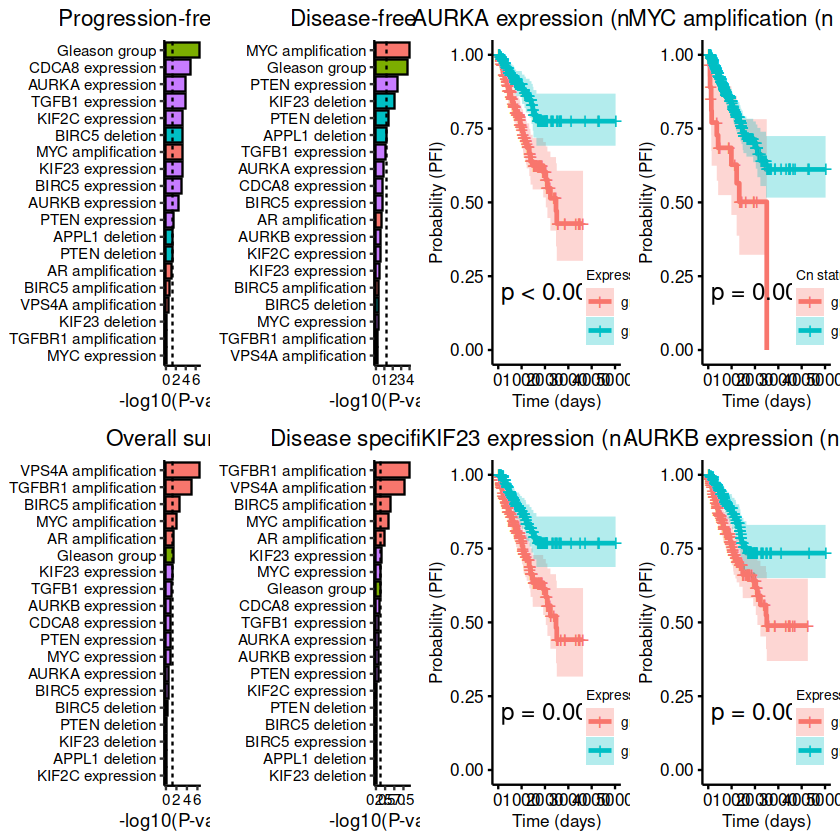

In [25]:
figure1

# 1.7 Prepare Figure Supplementary figure 1

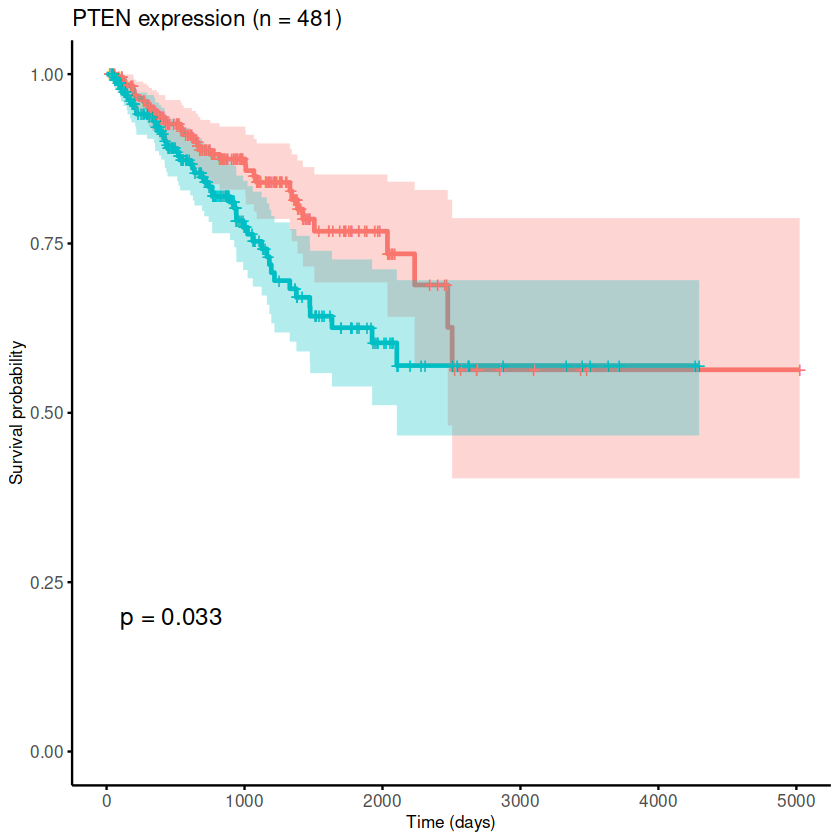

In [68]:
km.plots.ls[["PFI"]][["exp"]]["PTEN"]$PTEN

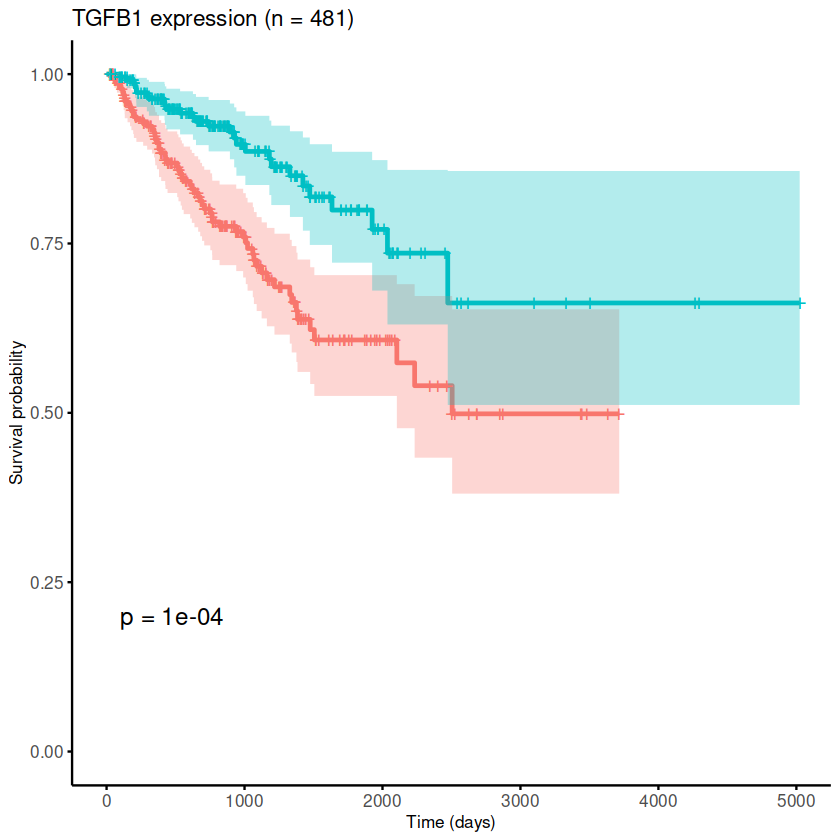

In [77]:
km.plots.ls[["PFI"]][["exp"]]["TGFB1"]$TGFB1 

In [62]:
a = km.plots.ls[["PFI"]][["exp"]]["PTEN"]$PTEN + theme(axis.text= element_text(size = 6)) + ggtitle("") + ylab("Probability (PFI)")
b = km.plots.ls[["DFI"]][["exp"]]["PTEN"]$PTEN + theme(axis.text= element_text(size = 6)) + ggtitle("") + ylab("Probability (DFI)")
c = km.plots.ls[["DFI"]][["cn.amp"]]["MYC"]$MYC + theme(axis.text= element_text(size = 6)) + ggtitle("") + ylab("Probability (DFI)")
d = km.plots.ls[["DFI"]][["cn.del"]]["PTEN"]$PTEN + theme(axis.text= element_text(size = 6)) + ggtitle("") + ylab("Probability (DFI)")
e = km.plots.ls[["PFI"]][["exp"]]["TGFB1"]$TGFB1 + theme(axis.text= element_text(size = 6)) + ggtitle("") + ylab("Probability (PFI)")

In [63]:
# Figure 1
figure_supple1 = plot_grid(a, b, c, d, e, nrow = 2)

In [64]:
ggsave(plot = figure_supple1, 
       filename = file.path("PRAD_specific_analysis/Figure_S1.pdf"), width = 8.16, height = 4.8)

# 1.8 Prepare Figure Supplementary figure 3

Extra figures 

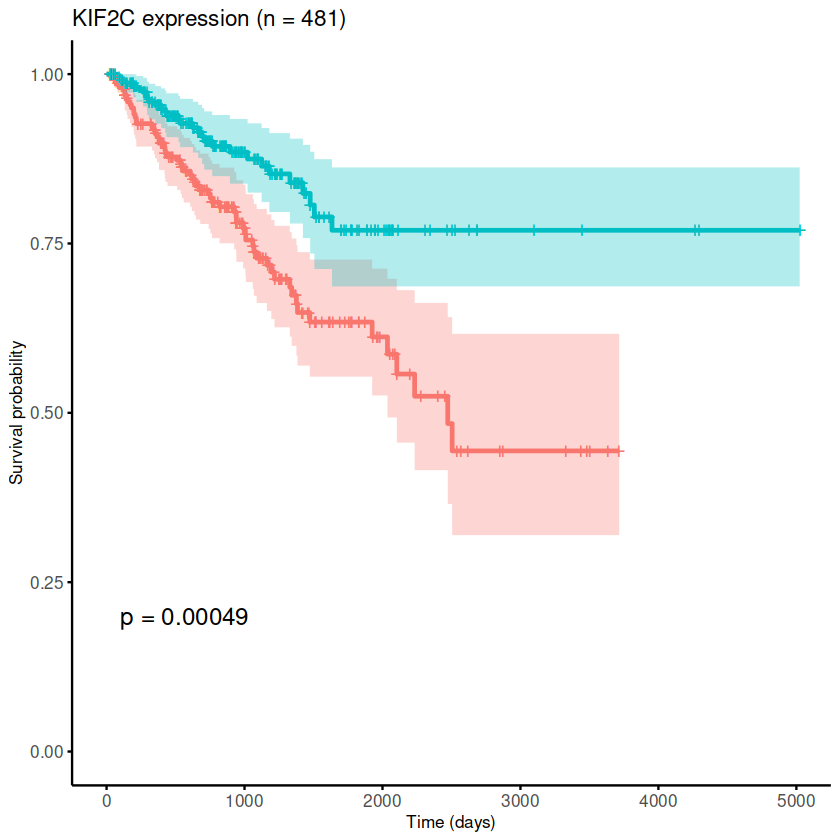

In [72]:
km.plots.ls[["PFI"]][["exp"]]["KIF2C"]$KIF2C

In [65]:
a = km.plots.ls[["PFI"]][["exp"]]["BIRC5"]$BIRC5 + theme(axis.text= element_text(size = 6)) + ggtitle("") + ylab("Probability (PFI)")
b = km.plots.ls[["PFI"]][["exp"]]["CDCA8"]$CDCA8 + theme(axis.text= element_text(size = 6)) + ggtitle("") + ylab("Probability (PFI)")
c = km.plots.ls[["PFI"]][["exp"]]["KIF2C"]$KIF2C + theme(axis.text= element_text(size = 6)) + ggtitle("") + ylab("Probability (PFI)")

In [66]:
# Figure 1
figure_supple3 = plot_grid(a, b, c, nrow = 1)

In [67]:
ggsave(plot = figure_supple3, 
       filename = file.path("PRAD_specific_analysis/Figure_S3.pdf"), width = 8, height = 2.4)

# 2. Univariate cox regression model

In [32]:
# 
# Function fits a cox regression model
# 
fitUnivCoxModel = function(data, end.point, feat){
    
    # Expand to variable name
    end_point_time = paste0(end.point, ".time.clin")
    end_point_event = paste0(end.point, ".clin")

    # Generate a survival formula object 
    survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
    f <- as.formula(paste(survExpression, feat, sep = " ~ "))
    model.fit = coxph(f, data = data)
    return(model.fit)
}

In [33]:
findReferenceLevel = function(x.train){
    
    # Iterate over tumor stages and find the ones to be 
    # removed 
    rem.train = c()

    # Levels 
    levs = c("Stage 1","Stage 2","Stage 3","Stage 4")

    # Iterate over the tumor stages (Training data)
    for (stage in levs){
        col = paste0("Tumor.stage",stage)
        if (col %in% colnames(x.train)) {
            if (sum(x.train[,col]) == 0){
                rem.train = c(rem.train, col)
            } else {
                rem.train = c(rem.train, col)
                break
            }
        } else {
            rem.train = c(rem.train, col)
        }
    }
    return(rem.train)
}

In [34]:
generateModelMatrix = function(train.data, 
                              clinical.endpoint){
    
    # Outcome variables
    time.var = paste0(clinical.endpoint, ".time.clin")
    status.var = paste0(clinical.endpoint, ".clin")
    
    # Remove possible zero time events which will cause errors.
    train.data <- dplyr::filter(train.data, !!rlang::sym(time.var) != 0)
    
    ### Outcome variables 
    
    # Extract events and time to event
    y.train = train.data %>% dplyr::select(all_of(c(status.var, time.var)))
    
    
    ### Predictors 
    
    # We keep the outcome variables in the model until the last step to
    # avoid collapsing the data into a vector given that only one predictor 
    # is present
    
    # Convert cn-features to factors 
    x.train = convertCnToFactors(train.data)

    # Create a model matrix
    # The CN features will be converted to dummy variables as the glmnet does 
    # not deal with factors. NOTE: THERE MIGHT BE NEED TO CHANGE THIS ENCODING
    x.train.mat = model.matrix(~ .-1, x.train)

    # Remove the Genderfemale column as it's the reference level for Gender
    x.train.mat = x.train.mat[, colnames(x.train.mat) != "Genderfemale"]

    # Remove Gleason group 1 as it¬¥s the reference level for Gleason group 
    x.train.mat = x.train.mat[, colnames(x.train.mat) != "Gleason.groupGleason group 1"]

    # Find the reference tumor stage 
    levs.rm = findReferenceLevel(x.train.mat)

    # Remove the lowest tumor stage which will be the reference level for the tumor stage 
    x.train.mat = removeReferenceTumorStage(x.train.mat, levs.rm)

    # Remove the reference condition for CN features 
    x.train.mat = dplyr::select(as.data.frame(x.train.mat), -contains(".cn0")) %>% 
                  as.matrix()
    
    return(x.train.mat)
}

In [35]:
# Store the results
cox.reg.results.ls = list()

In [36]:
findCoxZPH = function(fit.model){
    tryCatch({
         res = cox.zph(fit.model)
         return(res)
         }, error=function(e) {
            return(NULL)
         })
}

In [37]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # Data 
    comp.data = complete.data.ls[[end.point]]
      
    # Convert to model matrix
    model.input.data = generateModelMatrix(comp.data,
                                        clinical.endpoint = end.point)

    # Convert the cn feature names 
    colnames(model.input.data) = unlist(map_if(colnames(model.input.data), 
                                               str_ends(colnames(model.input.data), "-1") ,
                                               .f = function(x){str_replace(x, "cn-1", "cn.del")}))
    
    
    colnames(model.input.data) = unlist(map_if(colnames(model.input.data), 
                                               str_ends(colnames(model.input.data), "1") ,
                                               .f = function(x){str_replace(x, "cn1", "cn.amp")}))
    
    # Remove spaces from column names to avoid issues
    colnames(model.input.data) = map_chr(colnames(model.input.data), .f = function(x){str_replace_all(x, " ", "")}) 
    
    # Features
    feature.ls = colnames(model.input.data)[!(stringr::str_ends(colnames(model.input.data), ".clin"))]
    
    results.ls = list()
    
    for (feat in feature.ls){
        
        # Subset 
        subset.data = dplyr::select(as.data.frame(model.input.data), contains(".clin"), all_of(feat))
        if (str_detect(feat, ".cn") == T){
            subset.data = subset.data %>% 
                             mutate_if(str_detect(colnames(subset.data), ".cn"), as.factor)
            
            if (length(levels(subset.data[[feat]])) > 1) {
                fit.model = fitUnivCoxModel(subset.data, end.point, feat)
            } else {
                fit.model = NULL
            }
        } else {
            fit.model = fitUnivCoxModel(subset.data, end.point, feat)
        }     
        
        if (is.null(fit.model) != T) {
            
            tidy.res = tidy(fit.model, conf.int = TRUE, exponentiate = TRUE)
            
            if (is.na(tidy.res$p.value) == F){
                model.assump = findCoxZPH(fit.model)
                model.assump.pval = as.data.frame(model.assump$table)$p[1]
            } else {
                model.assump.pval = NA
            }
            # Rename columns 
            tidy.res = dplyr::rename(tidy.res, "Hazard ratio" = "estimate")
            tidy.res$zph.pval = model.assump.pval
        } else {
            tidy.res = NULL
        }
        # Update
        results.ls[[feat]] = tidy.res
    }
    cox.reg.results.ls[[end.point]] = bind_rows(results.ls, .id = "Feature")
}

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, c

In [38]:
for (end.point in c("OS","DSS","DFI","PFI")){
    write.csv(cox.reg.results.ls[[end.point]], file.path(dir.res.root, paste0("Cox_regression_analysis_", end.point, ".csv")))
}

# Visualise the Cox-regression results as a forest plot 

In [39]:
library(ggplot2)

Preprocess data

In [40]:
# Bind into a single table 
cox.reg.results.long = bind_rows(cox.reg.results.ls, .id = "Clin. end point")

In [41]:
# Keep only features significantly associated with atleast one clinincal end point
sigf.feat = unique(cox.reg.results.long$Feature[cox.reg.results.long$p.value < 0.05])
cox.reg.results.long = cox.reg.results.long %>% dplyr::filter(Feature %in% sigf.feat)

In [42]:
# Function for finalising feature names
fixFeatName = function(x){
    if (x == "Gleason.group.othGleasongroup2") {
        return("Gleason group")
    } else if (str_detect(x, "cn.amp")) {
        return(str_replace(x, ".cn.amp", " amplification"))
    } else if (str_detect(x, "cn.del")){
        return(str_replace(x, ".cn.del", " deletion"))
    } else if (str_detect(x, ".exp")){
        return(str_replace(x, ".exp", " expression"))
    } else {
        return(x)
    }
}


# Helper function
prepCI = function(x){
    res = paste(round(x[2:3], digits = 1), collapse = " - ")
    res = paste0(round(x[1], digits = 1)," (", res, ")")
    return(res)
}

# Set Confidence interval limits 
setCIlimit = function(x, lower, upper){
    x$conf.low = map_dbl(x$conf.low, function(x, lower){max(x, lower)}, lower = lower)
    x$conf.high = map_dbl(x$conf.high, function(x, upper){min(x, upper)}, upper = upper)
    return(x)
}

setHRlimit = function(x, upper){
    x[["Hazard ratio"]] = map_dbl(x[["Hazard ratio"]], function(x){min(x, upper)})
    return(x)
}


In [43]:
# Fix feature names
cox.reg.results.long$Feature = map_chr(cox.reg.results.long$Feature, fixFeatName)

# Restrict the confidence intervals
cox.reg.results.long = setCIlimit(cox.reg.results.long, lower = 0, upper = 80)

# Set hazard ratio as the maximum if exceeds 
cox.reg.results.long = setHRlimit(cox.reg.results.long, upper = 80)

In [44]:
cox.reg.results.long %>% dplyr::filter(Feature == "Gleason group")

Clin. end point,Feature,term,Hazard ratio,std.error,statistic,p.value,conf.low,conf.high,zph.pval
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OS,Gleason group,Gleason.group.othGleasongroup2,8.446210,1.115452e+00,1.912872893,5.576433e-02,0.9488279,75.185889,0.1295966
DSS,Gleason group,Gleason.group.othGleasongroup2,80.000000,1.123672e+04,0.001784257,9.985764e-01,0.0000000,80.000000,0.9999716
DFI,Gleason group,Gleason.group.othGleasongroup2,5.872811,5.386353e-01,3.286701227,1.013683e-03,2.0434254,16.878475,0.3369218
PFI,Gleason group,Gleason.group.othGleasongroup2,4.201669,2.998403e-01,4.787488671,1.688813e-06,2.3345187,7.562168,0.2983941


In [45]:
# Prepare pointrange plot 
pointrange.plot = cox.reg.results.long %>% ggplot() +
                                   geom_pointrange(aes(x = `Hazard ratio`, 
                                                       y = Feature, 
                                                       xmin = conf.low, 
                                                       xmax = conf.high, 
                                                       color = `Clin. end point`), 
                                                       position = position_dodge(width = 0.75), size=0.8) + 
                                                       theme_bw() + labs(y = NULL) + 
                                   scale_x_break(c(18, 20), scales = 0.5, expand = c(0,0)) +
                                   scale_x_continuous(limits = c(-1, 80), minor_breaks = NULL) +
                                   geom_vline(xintercept=1, linetype="dashed") +
                                   theme(legend.position = "none",
                                         axis.ticks.y = element_blank())

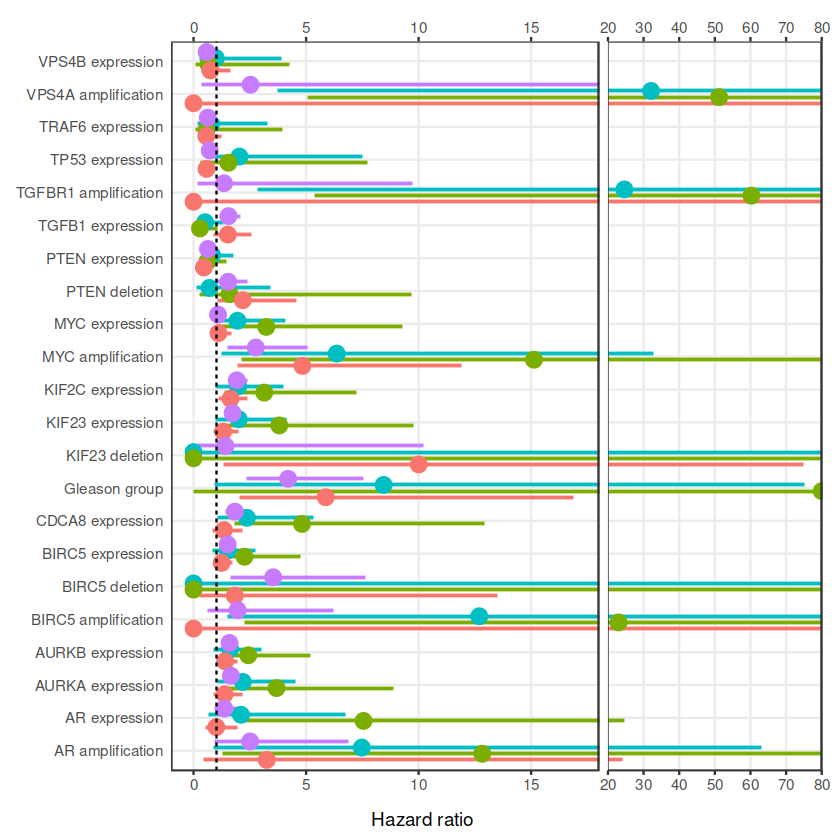

In [46]:
pointrange.plot

In [47]:
# Prepare a table display alognside the plot
tb.plt = cox.reg.results.long %>% 
              dplyr::select("Clin. end point", "Feature", "Hazard ratio", "p.value", "conf.low", "conf.high")
    
tb.plt$CI = tb.plt  %>% 
                  dplyr::select("Hazard ratio", conf.low, conf.high) %>% 
                  apply(1, prepCI)

tb.plt$p.value = as.character(format(tb.plt$p.value, digits = 4))
    
tb.plt.long = tb.plt  %>% 
                  dplyr::select(`Clin. end point`, Feature, p.value, CI) %>% 
                   pivot_longer(cols = c("p.value", "CI"), names_to = "stat", values_to = "value")

tb.plt.long$stat = factor(tb.plt.long$stat, levels = c("p.value", "CI"))

In [48]:
tb.plt.disp = tb.plt.long %>% 
             ggplot() + 
             geom_text(aes(y = stat ,
                           x = Feature,
                           group = `Clin. end point`,
                           label = value,
                           color = `Clin. end point`),
                           position = position_dodge(width = 0.75), 
                           size = 3) + coord_flip() + labs(y = NULL, x = NULL) + 
           theme_classic()  +
            theme(legend.position='none',
            strip.background = element_blank(),
            panel.grid.major = element_blank(),
            panel.border = element_blank(),
            axis.line = element_blank(),
            axis.text.y = element_blank(),
            axis.text.x = element_text(size = 12),
            axis.ticks = element_blank(),
            axis.title = element_text(face = "bold"))

In [49]:
dim.pointrange = get_dim(pointrange.plot)
tb.plt.disp.test = set_dim(tb.plt.disp, dim.pointrange)
forest.plt = pointrange.plot + tb.plt.disp.test + plot_layout(widths = c(2, 1))

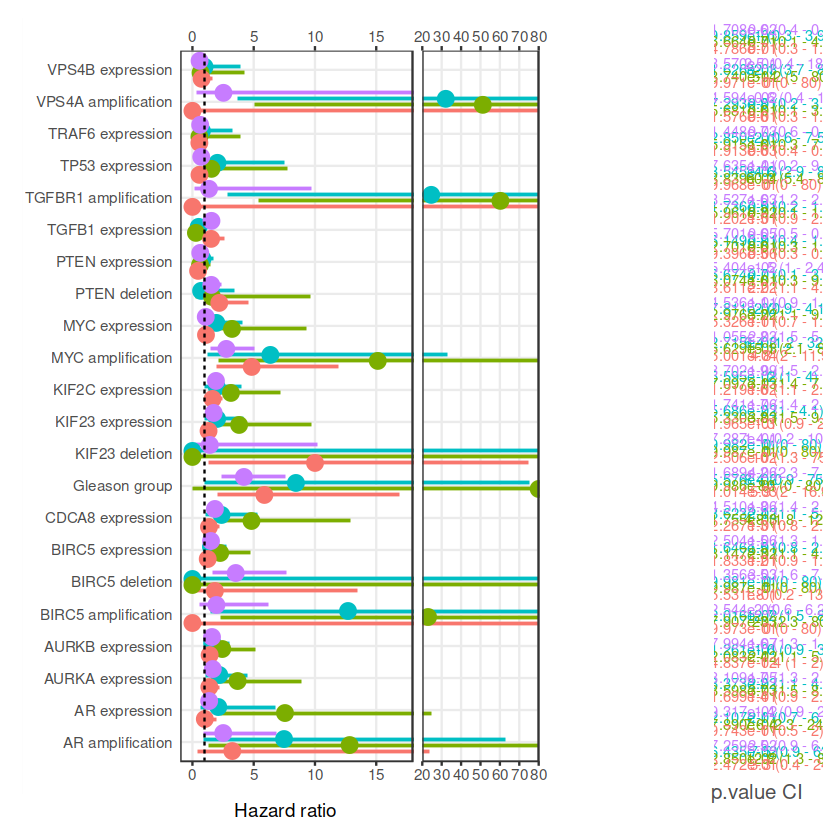

In [50]:
forest.plt

In [51]:
ggsave(forest.plt, filename = file.path(dir.res.root, "Cox_forest_plot_with_table.pdf"), width = 10, height = 18)

Functions for preparing forest plots

# Correlation of features and Gleason group 

## Expression vs Gleason group

This is mainly to possibly answer why models with gene based features as not much better than the reference models

In [52]:
library(ggpubr)
library(rstatix)


Attaching package: ‘rstatix’


The following object is masked from ‘package:IRanges’:

    desc


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:stats’:

    filter




In [53]:
colnames(tcga.dataset)[str_detect(colnames(tcga.dataset), "Gleason")]

[1] "Gleason.group.oth"

In [54]:
data.for.corr = tcga.dataset %>% 
         dplyr::select(Gleason.group.oth, one_of(paste0(gene.list,".exp")))

In [55]:
data.for.corr.long = data.for.corr %>% 
     pivot_longer(-Gleason.group.oth, names_to = "Feature", values_to = "Expression")

In [56]:
data.for.corr.long = data.for.corr.long[order(data.for.corr.long$Feature),]

In [57]:
stat.test <- data.for.corr.long %>%
  group_by(Feature) %>%
  t_test(Expression ~ Gleason.group.oth) %>% 
  add_xy_position(x = "Feature", dodge = 0.8)

In [58]:
stat.test

Feature,.y.,group1,group2,n1,n2,statistic,df,p,y.position,groups,x,xmin,xmax
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<named list>,<dbl>,<dbl>,<dbl>
APPL1.exp,Expression,Gleason group 1,Gleason group 2,194,306,-1.515470,393.7183,1.30e-01,13.95396,"Gleason group 1, Gleason group 2",1,0.8,1.2
APPL2.exp,Expression,Gleason group 1,Gleason group 2,194,306,-1.773987,420.5740,7.68e-02,14.56696,"Gleason group 1, Gleason group 2",2,1.8,2.2
AR.exp,Expression,Gleason group 1,Gleason group 2,194,306,-2.607361,460.7408,9.42e-03,17.54596,"Gleason group 1, Gleason group 2",3,2.8,3.2
AURKA.exp,Expression,Gleason group 1,Gleason group 2,194,306,-9.812849,481.2540,7.67e-21,12.39196,"Gleason group 1, Gleason group 2",4,3.8,4.2
AURKB.exp,Expression,Gleason group 1,Gleason group 2,194,306,-8.338776,490.1276,7.65e-16,11.30696,"Gleason group 1, Gleason group 2",5,4.8,5.2
BIRC5.exp,Expression,Gleason group 1,Gleason group 2,194,306,-8.905130,489.8380,1.04e-17,13.83396,"Gleason group 1, Gleason group 2",6,5.8,6.2
CDCA8.exp,Expression,Gleason group 1,Gleason group 2,194,306,-9.168858,491.9707,1.31e-18,12.20696,"Gleason group 1, Gleason group 2",7,6.8,7.2
KIF23.exp,Expression,Gleason group 1,Gleason group 2,194,306,-9.543498,492.9881,6.40e-20,11.64296,"Gleason group 1, Gleason group 2",8,7.8,8.2
KIF2C.exp,Expression,Gleason group 1,Gleason group 2,194,306,-10.327062,488.0090,9.59e-23,12.41496,"Gleason group 1, Gleason group 2",9,8.8,9.2


In [59]:
# Remove the exp-suffix 
data.for.corr.long$Feature = str_remove(data.for.corr.long$Feature, ".exp")
stat.test$Feature = str_remove(stat.test$Feature, ".exp")

In [60]:
# Prepare box plot 
boxplt.ggpubr = ggboxplot(data.for.corr.long, x = "Feature", y = "Expression",
                color = "Gleason.group.oth", palette =c("seagreen3","tomato2")) + stat_pvalue_manual(
                    stat.test,  label = "p", tip.length = 0.01)

# Save boxplot 
ggsave(plot = boxplt.ggpubr, filename = file.path(dir.res.root, "Gleason_vs_Exp_features_ggpubr.pdf"), height = 6, width = 12)

Warning message:
“Removed 85 rows containing non-finite values (stat_boxplot).”


Warning message:
“Removed 85 rows containing non-finite values (stat_boxplot).”


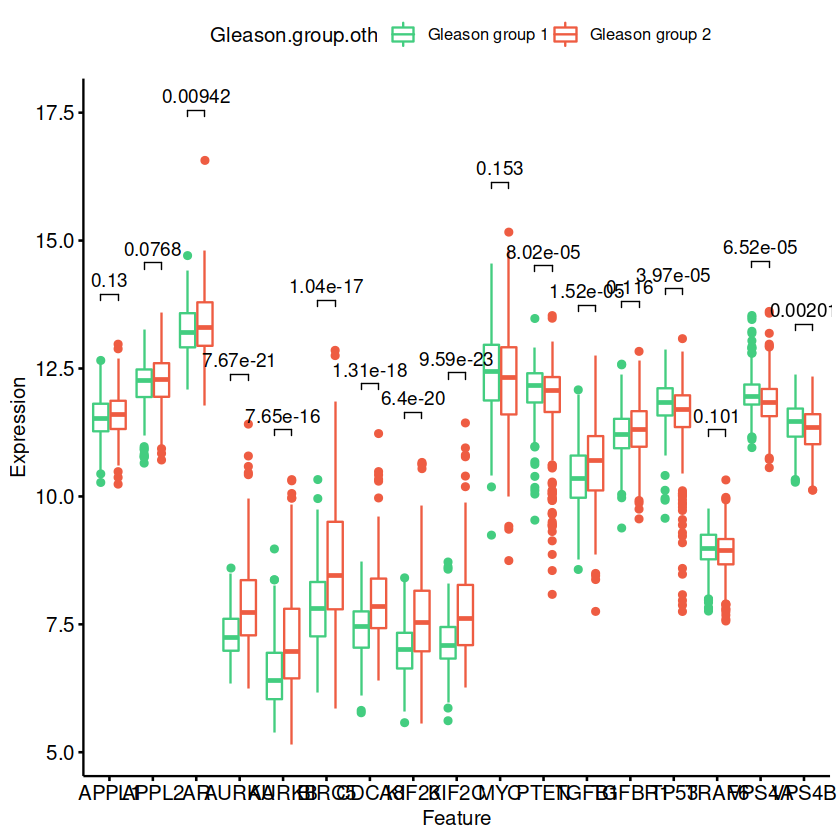

In [61]:
boxplt.ggpubr

## CN vs Gleason group

In [62]:
# The cn features
data.for.corr.cn = tcga.dataset %>% 
         dplyr::select(Gleason.group.oth, one_of(paste0(gene.list,".cn")))

In [63]:
# Recode CN features
recodeFeat = function(x){
    if (is.na(x) == T){
        return(NA)
    } else {
        if (x == 0){
            return("CN neutral")
        } else if (x == -1){
            return("CN deletion")
        } else {
            return("CN amplification")
        }     
    }
}

recodeCNfeat = function(x){
    x = map_chr(x, recodeFeat)
    return(x)
}

# Recode CN features
data.for.corr.cn = mutate_at(data.for.corr.cn, vars(contains(".cn")), recodeCNfeat)

In [64]:
# Long format 
data.for.corr.cn.long = data.for.corr.cn %>% 
                            tidyr::pivot_longer(-Gleason.group.oth, names_to = "Feature", values_to = "Status")

# Remove NA 
data.for.corr.cn.long = data.for.corr.cn.long[!is.na(data.for.corr.cn.long$Status),]

# Calculate counts for each feature according for both Gleason groups
data.for.corr.cn.count =  data.for.corr.cn.long %>% 
         group_by(Feature, Gleason.group.oth, Status) %>% 
         summarise(n = n())

# Assign factor levels 
data.for.corr.cn.count$Status = factor(data.for.corr.cn.count$Status, levels = c("CN deletion", "CN neutral", "CN amplification"))

`summarise()` has grouped output by 'Feature', 'Gleason.group.oth'. You can
override using the `.groups` argument.


In [65]:
gg.cn.bar = ggbarplot(data.for.corr.cn.count, 
                      x = "Status", 
                      y = "n", 
                      fill = "Gleason.group.oth", 
                      facet.by = "Feature", 
                      nrow = 1, palette =c("seagreen3","tomato2")) + rotate_x_text(45)

In [66]:
ggsave(plot = gg.cn.bar, filename = file.path(dir.res.root, "Gleason_vs_CN_features.pdf"), height = 12, width = 16)

Calculate the p-values between neutral - deletion and neutral - amplification

In [67]:
# Calculate p-value for Fisher´s exact test
calculateFisher = function(x){
    x = x[,-1]
    mat = as.matrix(x[,c("Gleason group 1","Gleason group 2")])
    rownames(mat) = x$Status
    test = pairwise_fisher_test(mat)
    
    # Based on the total count find appropriate position based on the maximum of the row sums
    test$y.position = max(rowSums(mat)) + seq(from = 10, 
                                              by = 20,
                                              length.out = nrow(test))
    
    return(test)
}


# Function for adding xy coordinates for p-value labels
add_xy_custom = function(x, group.levels = c("CN deletion", "CN neutral", "CN amplification")){
    
    # Determine the xmin and xmax based on factor level 
    group.1.idx = unlist(map(x$group1, function(x, levs){which(x == levs)}, levs = group.levels))
    group.2.idx = unlist(map(x$group2, function(x, levs){which(x == levs)}, levs = group.levels))
    
    xmin = apply(data.frame(A = group.1.idx, B = group.2.idx),1, min)
    xmax = apply(data.frame(A = group.1.idx, B = group.2.idx),1, max)
    
    x$xmin = xmin
    x$xmax = xmax
    return(x)
}

In [68]:
# Convert counts to wide format
data.for.corr.cn.count.wider = data.for.corr.cn.count %>% 
     pivot_wider(names_from = "Gleason.group.oth", values_from = "n")

data.for.corr.cn.count.wider[is.na(data.for.corr.cn.count.wider)] = 0

In [69]:
# Calculate Fisher´s exact test p-values and add xy-coords for labels
data.for.corr.cn.count.wider.sp = split(data.for.corr.cn.count.wider, data.for.corr.cn.count.wider$Feature)
data.for.corr.cn.count.wider.sp.fisher = map(data.for.corr.cn.count.wider.sp, calculateFisher)
data.for.corr.cn.count.wider.sp.fisher = map(data.for.corr.cn.count.wider.sp.fisher, add_xy_custom)
data.for.corr.cn.count.wider.sp.fisher.df = bind_rows(data.for.corr.cn.count.wider.sp.fisher, .id = "Feature")

In [70]:
# Remove the comparisons we are not interested in deletion-amplification
removeComparison = function(x, g1, g2){
    groups = c(g1, g2)
    in.group1 = map_lgl(x$group1, function(x, groups){x %in% groups}, groups = groups)
    in.group2 = map_lgl(x$group2, function(x, groups){x %in% groups}, groups = groups)
    keep.comp = (in.group1 + in.group2) < 2
    return(x[keep.comp,])
}
data.for.corr.cn.count.wider.sp.fisher.df.final = removeComparison(data.for.corr.cn.count.wider.sp.fisher.df , g1 = "CN deletion", g2 = "CN amplification")

In [71]:
gg.cn.bar = ggbarplot(data.for.corr.cn.count, x = "Status", y = "n", 
                      fill = "Gleason.group.oth", 
                      facet.by = "Feature", nrow = 4, palette =c("#d38d5f","#e9afdd")) + rotate_x_text(45) + 
       stat_pvalue_manual(data.for.corr.cn.count.wider.sp.fisher.df.final, label = "p", tip.length = 0.01, size = 2) + 
      scale_y_continuous(expand = expansion(c(0, 0.05))) + theme(text = element_text(size = 6))

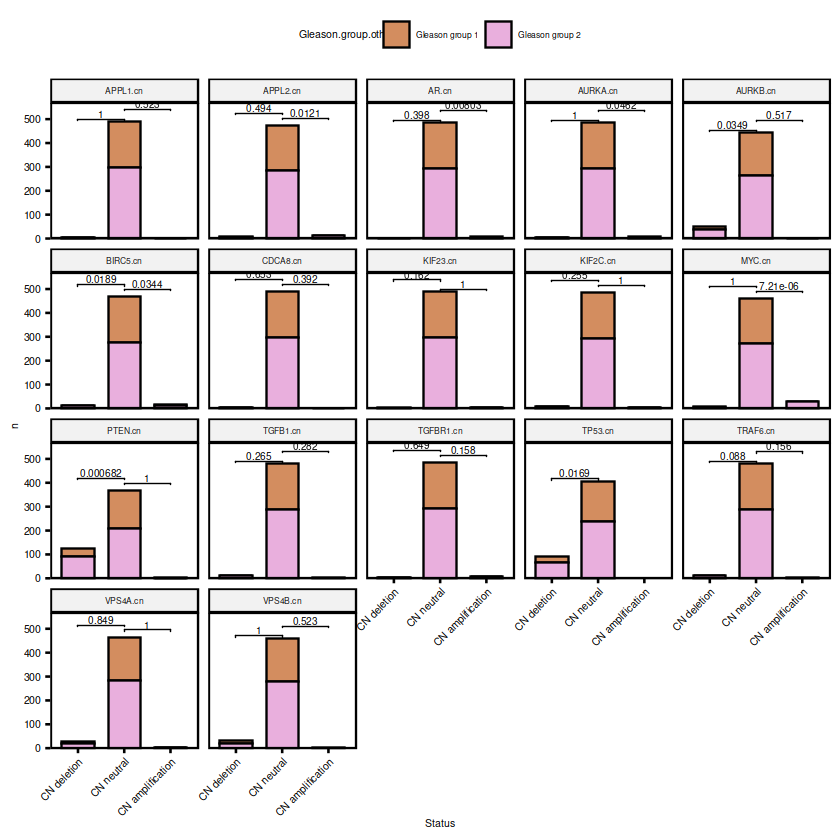

In [72]:
gg.cn.bar

In [73]:
ggsave(plot = gg.cn.bar, filename = file.path(dir.res.root, "Gleason_vs_CN_features_with_pval.pdf"), height = 12, width = 4.28)

In [74]:
ggsave(plot = gg.cn.bar, filename = "Gleason_vs_CN_features_with_pval.pdf", height = 8, width = 4.28)

In [75]:
getwd()

[1] "/home/data/project_code/landstrom_core/prognostic_model_development/r/notebooks"

# Session info

In [76]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: AlmaLinux 8.5 (Arctic Sphynx)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.12.so

locale:
 [1] LC_CTYPE=C.UTF-8           LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] rstatix_0.7.0               DESeq2_1.34.0              
 [3] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [5] MatrixGenerics_1.6.0        matrixStats_0.62.0         
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_2.28.0              S4Vectors